In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.datasets import support

from pycox.models import LogisticHazard
from pycox.models import CoxPH
from pycox.models import PCHazard
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv


In [2]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

# Load Data and Pre-Processing

In [3]:
df = metabric.read_df()
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [5]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# DeepSurv

In [6]:
# Processing labels
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [7]:
# Build Models
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)


In [8]:
# Train the model
batch_size = 256
epochs = 100
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)

model.optimizer.set_lr(lrfinder.get_best_lr())
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 5.3011,	val_loss: 4.4769
1:	[0s / 0s],		train_loss: 4.7637,	val_loss: 4.4074
2:	[0s / 0s],		train_loss: 4.7031,	val_loss: 4.0497
3:	[0s / 0s],		train_loss: 4.7036,	val_loss: 4.0853
4:	[0s / 0s],		train_loss: 4.6486,	val_loss: 3.9770
5:	[0s / 0s],		train_loss: 4.6175,	val_loss: 3.9723
6:	[0s / 0s],		train_loss: 4.6161,	val_loss: 3.9730
7:	[0s / 0s],		train_loss: 4.6068,	val_loss: 3.9245
8:	[0s / 0s],		train_loss: 4.6051,	val_loss: 3.9519
9:	[0s / 0s],		train_loss: 4.5765,	val_loss: 3.9485
10:	[0s / 0s],		train_loss: 4.5990,	val_loss: 3.9118
11:	[0s / 0s],		train_loss: 4.5740,	val_loss: 3.9678
12:	[0s / 0s],		train_loss: 4.5925,	val_loss: 3.9330
13:	[0s / 0s],		train_loss: 4.5666,	val_loss: 3.9175
14:	[0s / 0s],		train_loss: 4.5577,	val_loss: 3.9477
15:	[0s / 0s],		train_loss: 4.5663,	val_loss: 3.9541
16:	[0s / 0s],		train_loss: 4.5662,	val_loss: 3.9536
17:	[0s / 0s],		train_loss: 4.5396,	val_loss: 3.9600
18:	[0s / 0s],		train_loss: 4.5660,	val_loss: 3.9733
19:

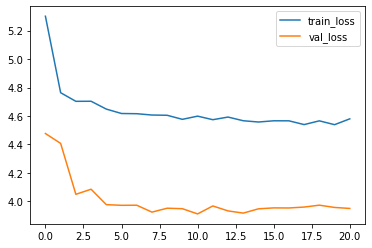

In [9]:
_ = log.plot()


In [10]:
# Evaluate the model
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw, brier_score

def eval_single(df_train_all, model, test_set, val_batch_size=None):
    get_target = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    
    horizons = [0.25, 0.5, 0.75]
    times = np.quantile(df["duration"][df["event"]==1.0], horizons).tolist()
    

    df_test, df_y_test = test_set
    _ = model.compute_baseline_hazards()
    surv = model.predict_surv(df_test, batch_size=val_batch_size)
    risk = 1 - surv

    durations_test, events_test = get_target(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    metric_dict = defaultdict(list)

    cis = []
    for i, _ in enumerate(times):
        cis.append(
            concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
            )
        metric_dict[f'{horizons[i]}_ipcw'] = cis[i]
#         metric_dict[f'{horizons[i]}_brier'] = brs[i]


    for horizon in enumerate(horizons):
        print(f"For {horizon[1]} quantile,")
        print("TD Concordance Index - IPCW:", cis[horizon[0]])

    return metric_dict

In [11]:
df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.6503412661940065
For 0.5 quantile,
TD Concordance Index - IPCW: 0.6598205985635893
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6521704234101725


defaultdict(list,
            {'0.25_ipcw': 0.6503412661940065,
             '0.5_ipcw': 0.6598205985635893,
             '0.75_ipcw': 0.6521704234101725})

# DeepHit

In [12]:
# Processing Labels
labtrans = DeepHitSingle.label_transform(cuts=20)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [13]:
# Build the model and train
in_features = x_train.shape[1]
num_nodes = [32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [14]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 0.7739,	val_loss: 0.6114
1:	[0s / 0s],		train_loss: 0.6969,	val_loss: 0.6068
2:	[0s / 0s],		train_loss: 0.6817,	val_loss: 0.6043
3:	[0s / 0s],		train_loss: 0.6598,	val_loss: 0.6026
4:	[0s / 0s],		train_loss: 0.6617,	val_loss: 0.6045
5:	[0s / 0s],		train_loss: 0.6508,	val_loss: 0.6005
6:	[0s / 0s],		train_loss: 0.6461,	val_loss: 0.5987
7:	[0s / 0s],		train_loss: 0.6369,	val_loss: 0.5972
8:	[0s / 0s],		train_loss: 0.6299,	val_loss: 0.5961
9:	[0s / 0s],		train_loss: 0.6351,	val_loss: 0.5973
10:	[0s / 0s],		train_loss: 0.6243,	val_loss: 0.5995
11:	[0s / 0s],		train_loss: 0.6241,	val_loss: 0.5947
12:	[0s / 0s],		train_loss: 0.6243,	val_loss: 0.5935
13:	[0s / 0s],		train_loss: 0.6261,	val_loss: 0.5915
14:	[0s / 0s],		train_loss: 0.6112,	val_loss: 0.5920
15:	[0s / 0s],		train_loss: 0.6129,	val_loss: 0.5904
16:	[0s / 0s],		train_loss: 0.6199,	val_loss: 0.5926
17:	[0s / 0s],		train_loss: 0.6072,	val_loss: 0.5912
18:	[0s / 0s],		train_loss: 0.6155,	val_loss: 0.5925
19:

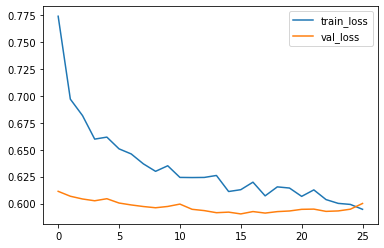

In [15]:
_ = log.plot()


In [16]:
# Evaluate the model

def eval_single(df_train_all, model, test_set, val_batch_size=None):
    get_target = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    
    horizons = [0.25, 0.5, 0.75]
    times = np.quantile(df["duration"][df["event"]==1.0], horizons).tolist()
    

    df_test, df_y_test = test_set
    surv = model.predict_surv(df_test, batch_size=val_batch_size)
    risk = 1 - surv

    durations_test, events_test = get_target(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    metric_dict = defaultdict(list)

    cis = []
    for i, _ in enumerate(times):
        cis.append(
            concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
            )
        metric_dict[f'{horizons[i]}_ipcw'] = cis[i]
#         metric_dict[f'{horizons[i]}_brier'] = brs[i]


    for horizon in enumerate(horizons):
        print(f"For {horizon[1]} quantile,")
        print("TD Concordance Index - IPCW:", cis[horizon[0]])

    return metric_dict

df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.7185865233805391
For 0.5 quantile,
TD Concordance Index - IPCW: 0.6696828138002664
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6699457081446825


defaultdict(list,
            {'0.25_ipcw': 0.7185865233805391,
             '0.5_ipcw': 0.6696828138002664,
             '0.75_ipcw': 0.6699457081446825})

# PC-Hazard 

In [17]:
# Processing labels
num_durations = 10
labtrans = PCHazard.label_transform(cuts=num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [18]:
# Build the model and train
in_features = x_train.shape[1]
num_nodes = [32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)



In [19]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 2.8821,	val_loss: 2.7204
1:	[0s / 0s],		train_loss: 2.8190,	val_loss: 2.7494
2:	[0s / 0s],		train_loss: 2.8131,	val_loss: 2.7432
3:	[0s / 0s],		train_loss: 2.7737,	val_loss: 2.7240
4:	[0s / 0s],		train_loss: 2.7260,	val_loss: 2.6937
5:	[0s / 0s],		train_loss: 2.6924,	val_loss: 2.6654
6:	[0s / 0s],		train_loss: 2.6492,	val_loss: 2.6344
7:	[0s / 0s],		train_loss: 2.6316,	val_loss: 2.6031
8:	[0s / 0s],		train_loss: 2.6045,	val_loss: 2.5764
9:	[0s / 0s],		train_loss: 2.5895,	val_loss: 2.5462
10:	[0s / 0s],		train_loss: 2.5710,	val_loss: 2.5164
11:	[0s / 0s],		train_loss: 2.5443,	val_loss: 2.4870
12:	[0s / 0s],		train_loss: 2.5042,	val_loss: 2.4522
13:	[0s / 0s],		train_loss: 2.4969,	val_loss: 2.4221
14:	[0s / 0s],		train_loss: 2.4679,	val_loss: 2.3971
15:	[0s / 0s],		train_loss: 2.4111,	val_loss: 2.3664
16:	[0s / 0s],		train_loss: 2.3961,	val_loss: 2.3398
17:	[0s / 0s],		train_loss: 2.3680,	val_loss: 2.3080
18:	[0s / 0s],		train_loss: 2.3408,	val_loss: 2.2706
19:

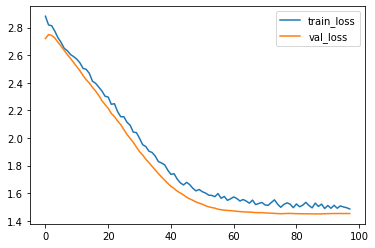

In [20]:
_ = log.plot()


In [21]:
df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.7121575867085904
For 0.5 quantile,
TD Concordance Index - IPCW: 0.6813192586043595
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6525598809965008


defaultdict(list,
            {'0.25_ipcw': 0.7121575867085904,
             '0.5_ipcw': 0.6813192586043595,
             '0.75_ipcw': 0.6525598809965008})